In [1]:
"""
Movie Recommender AI using Naive Bayes 
"""

import numpy as np
from collections import defaultdict

data_path = 'movie-dataset/ratings.csv'
n_users = 671
n_movies = 9125

In [2]:
def load_rating_data(data_path, n_users, n_movies):
    """
    Load rating data from file and also return the number of
    ratings for each movie and movie_id index mapping
    @param data_path: path of the rating data file
    @param n_users: number of users
    @param n_movies: number of movies that have ratings
    @return: rating data in the numpy array of [user, movie];
            movie_n_rating, {movie_id: number of ratings};
            movie_id_mapping, {movie_id: column index in
            rating data}
    """
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, movie_id, rating, _ = line.split(',')
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            rating = int(float(rating))
            data[user_id, movie_id_mapping[movie_id]] = rating
            if rating > 0:
                movie_n_rating[movie_id] += 1
    return data, movie_n_rating, movie_id_mapping

In [3]:
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

In [4]:
# Check the data distribution
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f"Number of rating {int(value)}: {count}")

display_distribution(data)

Number of rating 0: 6023972
Number of rating 1: 5013
Number of rating 2: 11720
Number of rating 3: 30602
Number of rating 4: 36473
Number of rating 5: 15095


In [5]:
# Take movie with highest known rating as target movie
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]
print(f"Movie ID {movie_id_most} has {n_rating_most} ratings.")

Movie ID 356 has 341 ratings.


In [6]:
# Remove target movie from the signals
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis = 1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

In [7]:
# Discard sample without a rating
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]

# Check
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (341, 9124)
Shape of Y: (341,)


In [8]:
# Distribution of target movie ratings
display_distribution(Y)

Number of rating 1: 5
Number of rating 2: 16
Number of rating 3: 69
Number of rating 4: 149
Number of rating 5: 102


In [9]:
# Consider movies with ratings greater than 3 as being liked
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()

# Always analyze the label distribution and see how balanced the dataset is
# in solving classification problems

print(f"{n_pos} positive samples and {n_neg} negative samples.")

251 positive samples and 90 negative samples.


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check tranining and testing size
print(len(Y_train), len(Y_test))

272 69


In [11]:
# Use multinomial naive bayes
# because input features are 0 to 5 instead of 0 / 1
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

# Make prediction
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[:10])

[[2.98656769e-001 7.01343231e-001]
 [1.00000000e+000 3.34643691e-106]
 [3.61589763e-001 6.38410237e-001]
 [4.79228837e-071 1.00000000e+000]
 [3.47883427e-046 1.00000000e+000]
 [5.37136821e-012 1.00000000e+000]
 [5.56623948e-063 1.00000000e+000]
 [1.61299204e-060 1.00000000e+000]
 [3.27810509e-020 1.00000000e+000]
 [9.09364919e-033 1.00000000e+000]]


In [12]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
accuracy = clf.score(X_test, Y_test)
print(f"The accuracy is: {accuracy*100:.1f}%")

The accuracy is: 69.6%


In [14]:
# Evaluating Classification Performance
# Other than accuracy, we can use:
# confusion matrix
# recall
# F1 score
# Area under the curve

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 4 15]
 [ 6 44]]


In [15]:
# 4 true negative cases where the model correctly identify dislike
# 15 false positive cases where the model misinterprets a dislike as a like
# 6 false negative cases where the model fails to detect a like for a movie
# 44 true positive cases where the model correctly identify like

# Classification accuracy is proportion of all true cases:
# (TN + TP) / (TN + FN + TP + FP)
# (4 + 44) / (4 + 6 + 15 + 44)
# 69.6%

# Precision measures the fraction of positive calls that are correct
# TP / (TP + FP)
# 44 / (44 + 15)
# 74.6%

# Recall (true positive rate) measures the fraction of true positives that are correctly identified
# TP / (TP + FN)
# 44 / (44 + 6)
# 88%

# F1 score includes both precision and recall
# equates to their harmonic mean
# f1 = 2 * (precision*recall / (precision+recall))

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(Y_test, prediction, pos_label=1)

0.7457627118644068

In [17]:
recall_score(Y_test, prediction, pos_label=1)

0.88

In [18]:
f1_score(Y_test, prediction, pos_label=1)

0.8073394495412843

In [19]:
# On the other hand, negative class can also be viewed as positive, depending on the context
f1_score(Y_test, prediction, pos_label=0)

0.27586206896551724

In [20]:
# Shorthand
from sklearn.metrics import classification_report

report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.40      0.21      0.28        19
         1.0       0.75      0.88      0.81        50

    accuracy                           0.70        69
   macro avg       0.57      0.55      0.54        69
weighted avg       0.65      0.70      0.66        69



In [21]:
# Receiver operating characteristics (ROC)
pos_prob = prediction_prob[:, 1]
tresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(tresholds), [0]*len(tresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, treshold in enumerate(tresholds):
        if pred >= treshold:
            # if truth and prediction are both 1
            if y == 1:
                true_pos[i] += 1
            # if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break

n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

No handles with labels found to put in legend.


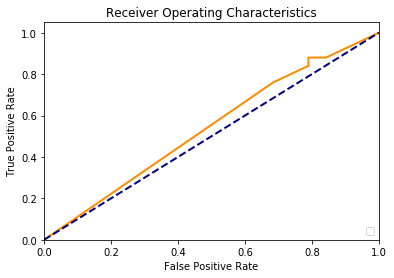

In [22]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Compute area under curve
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, pos_prob)

0.5442105263157895

In [24]:
# What AUC value leads to the conclusion that a classifier is good?
# Unfortunately, there is no such "magic" number. We use the
# following rule of thumb as general guidelines: classification models
# achieving an AUC of 0.7 to 0.8 are considered acceptable, 0.8 to 0.9
# are great, and anything above 0.9 are superb. Again, in our case,
# we are only using the very sparse movie rating data. Hence, an
# AUC of 0.69 is actually acceptable.

In [25]:
# K-fold cross validation
from sklearn.model_selection import StratifiedKFold
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

In [26]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

# for each fold generated by the split() method of the k_fold object, we
# repeat the process of classifier initialization, training, and prediction with one of the
# aforementioned combinations of parameters, and record the resulting AUCs

for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in  fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f"\t{smoothing}\t{fit_prior}\t{auc/k:.5f}")

	1	True	0.57792
	1	False	0.57658
	2	True	0.56252
	2	False	0.57411
	3	True	0.53393
	3	False	0.53393
	4	True	0.54367
	4	False	0.54178
	5	True	0.54463
	5	False	0.54897
	6	True	0.53541
	6	False	0.53541


In [27]:
# alpha 1 with fit_prior = True has the best AUC

clf = MultinomialNB(alpha=1, fit_prior=True)
clf.fit(X_train, Y_train)
prediction_prob = clf.predict_proba(X_test)
pos_prob = prediction_prob[:, 1]

print("AUC with the best model: ", roc_auc_score(Y_test, pos_prob))

AUC with the best model:  0.6066666666666667
